File: detect_touch_led.ipynb  
Author: Luciano Orlandini  
Created: March, 2022  
  
Description:  
File includes data analysis and training of Machine Learning algorithm  
to detect user touch on the Gadget Board with LED.  
  
Accuracy:  
LED - Detects if touch is on onde of the 144 single LEDs.

Load dataset file as Pandas dataframe and display head.

In [1]:
import pandas as pd

# Load and shuffle database
path = 'data_handler/data/'
data = pd.read_csv(path + 'simon_led.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
print('Original Shape: ', data.shape)

# Remove outliers
for i in range (0, 144):
    indexes = data[ (data[str(i)] < 450) | (data[str(i)] > 650) ].index
    data.drop(indexes, inplace=True)
data.reset_index(drop=True, inplace=True)
print('Filtered Shape: ', data.shape)

     0    1    2    3    4    5    6    7    8    9  ...  135  136  137  138  \
0  586  594  582  580  578  586  585  588  586  587  ...  536  547  541  546   
1  588  590  580  581  580  585  582  588  588  586  ...  538  540  543  547   
2  574  583  574  572  567  575  577  581  578  576  ...  554  560  561  562   
3  578  585  574  572  570  580  578  582  580  583  ...  538  542  544  545   
4  579  588  579  577  572  581  583  587  586  585  ...  556  563  565  560   

   139  140  141  142  143  144  
0  540  540  539  533  542   54  
1  542  540  538  532  541   34  
2  558  560  555  550  558  119  
3  542  541  540  536  539   19  
4  563  564  561  555  558   15  

[5 rows x 145 columns]
Original Shape:  (43828, 145)
Filtered Shape:  (36968, 145)


Separate dataframe in input ***X*** and output ***y***.  
Every row in ***X*** will have a corresponding output on the same row  
in ***y***.
Additionaly, data is sclaed to work in LogisticRegression classifier.

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X = data.iloc[:,:-1]
y = data['144']
unique_outputs = set(y)
n_unique_outputs = len(unique_outputs)

scaler = MinMaxScaler()
X = scaler.fit_transform(X.values, y.values)

min_max = open("min_max_led.txt", "w")
np.savetxt(min_max, scaler.data_min_)
np.savetxt(min_max, scaler.data_max_)
min_max.close()

X = X.astype(dtype='float32')
y = y.to_numpy(dtype='float32')

Plot histrogram of ***y*** to show distribution of quantities for each  
different output.

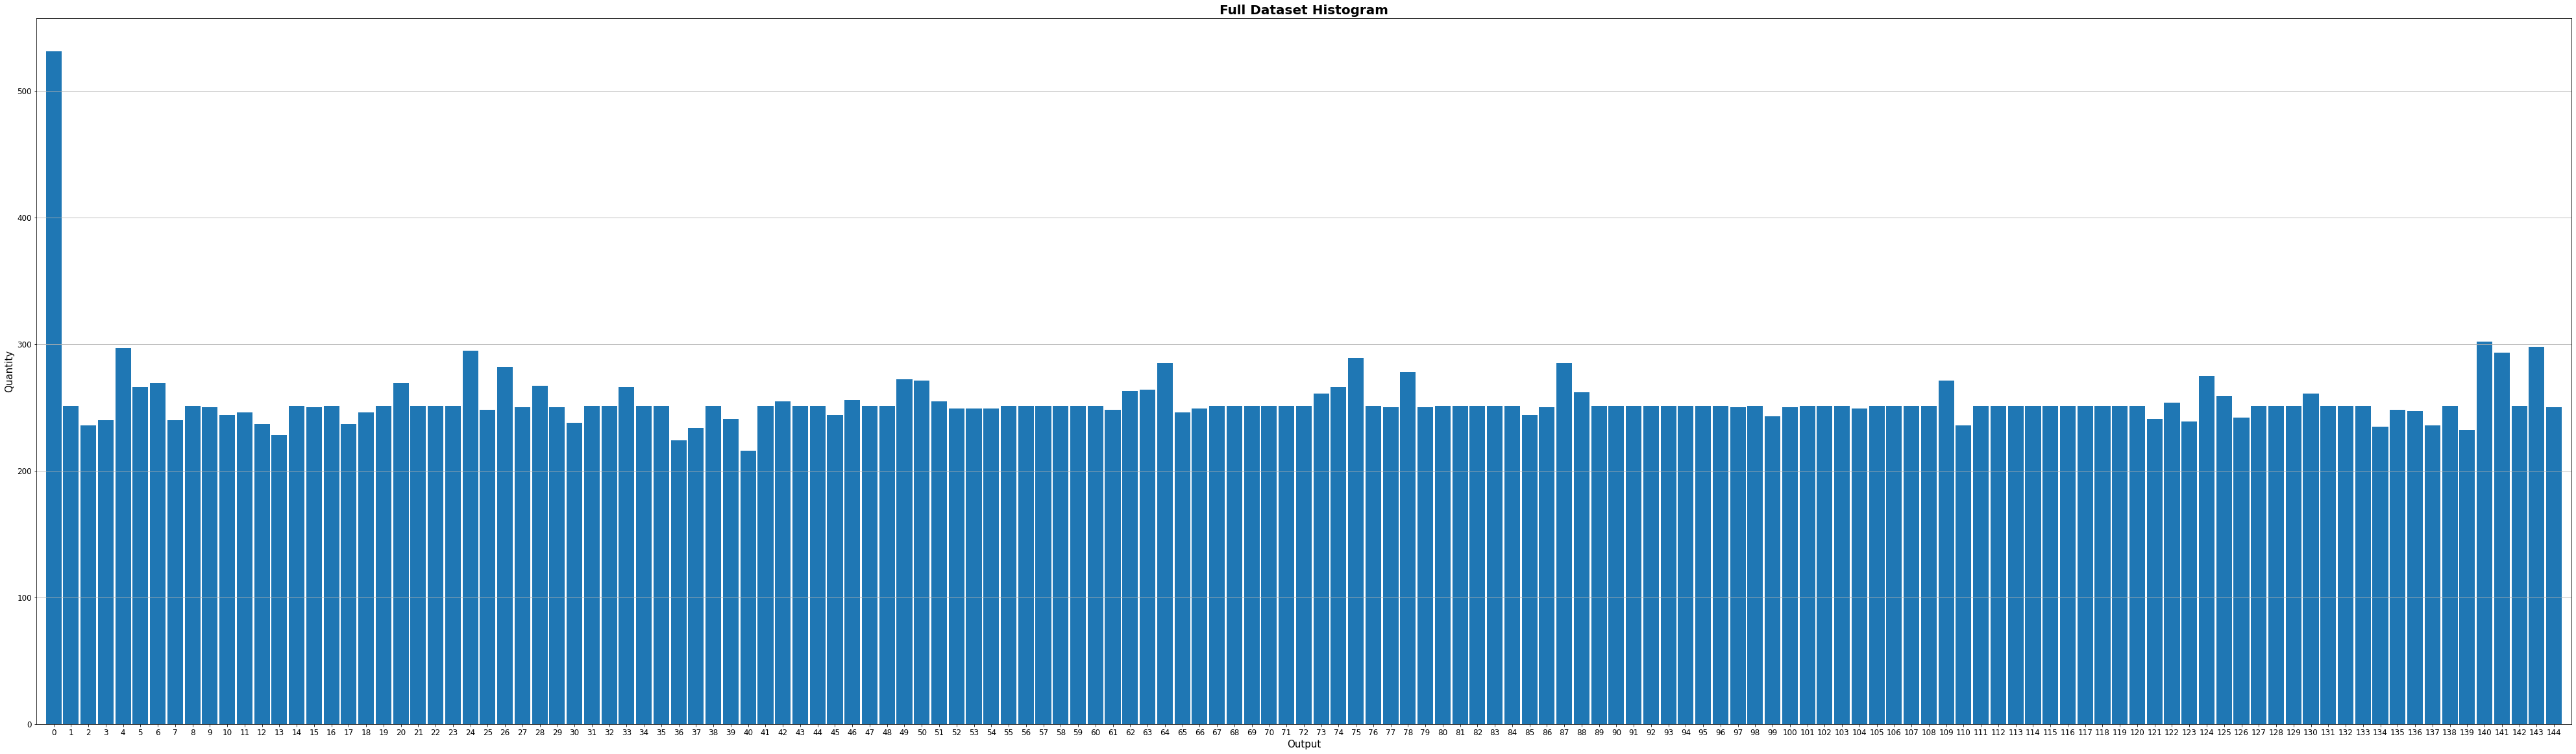

In [3]:
import matplotlib .pyplot as plt

plt.figure(figsize=(70,20))
plt.hist(data['144'], bins=np.arange(n_unique_outputs+1)-0.5, rwidth=0.9)
plt.title('Full Dataset Histogram', fontsize=20, fontweight='bold')
plt.xlabel('Output', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.xticks(range(n_unique_outputs), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-1, n_unique_outputs)
plt.grid(axis='y')
plt.show()

Split data into train and test data.

In [4]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [    0     1     3 ... 36965 36966 36967] TEST: [    2     4     7 ... 36945 36954 36958]
TRAIN: [    1     2     3 ... 36961 36963 36966] TEST: [    0     9    10 ... 36964 36965 36967]
TRAIN: [    0     1     2 ... 36964 36965 36967] TEST: [    3     8    12 ... 36952 36963 36966]
TRAIN: [    0     2     3 ... 36965 36966 36967] TEST: [    1     5     6 ... 36959 36960 36961]


Create neural network using TensorFlow's Keras Sequential model.

In [5]:
# Disable TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

neural_net = tf.keras.Sequential()

neural_net.add(tf.keras.Input(shape=(144,)))
# neural_net.add(tf.keras.layers.Dense(2, activation='relu'))
# neural_net.add(tf.keras.layers.Dropout(0.1))
neural_net.add(tf.keras.layers.Dense(145, activation='softmax'))

neural_net.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

neural_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 145)               21025     
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


Fit model.

In [6]:
EPOCHS = 25

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = neural_net.fit(
    X[train_index],
    y[train_index],
    epochs=EPOCHS,
    batch_size=1,
    validation_data=(X[test_index], y[test_index]),
    callbacks=[model_checkpoint_callback]
)

neural_net.load_weights(checkpoint_filepath)

Epoch 1/25
27726/27726 [==============================] - 43s 2ms/step - loss: 4.7082 - accuracy: 0.0378 - val_loss: 4.2345 - val_accuracy: 0.1139
Epoch 2/25
27726/27726 [==============================] - 41s 1ms/step - loss: 3.9643 - accuracy: 0.1465 - val_loss: 3.6524 - val_accuracy: 0.1951
Epoch 3/25
27726/27726 [==============================] - 43s 2ms/step - loss: 3.4229 - accuracy: 0.2893 - val_loss: 3.1731 - val_accuracy: 0.3443
Epoch 4/25
27726/27726 [==============================] - 46s 2ms/step - loss: 2.9732 - accuracy: 0.4470 - val_loss: 2.7742 - val_accuracy: 0.4958
Epoch 5/25
27726/27726 [==============================] - 50s 2ms/step - loss: 2.5781 - accuracy: 0.5869 - val_loss: 2.4080 - val_accuracy: 0.6156
Epoch 6/25
27726/27726 [==============================] - 46s 2ms/step - loss: 2.2283 - accuracy: 0.6921 - val_loss: 2.0628 - val_accuracy: 0.7549
Epoch 7/25
27726/27726 [==============================] - 47s 2ms/step - loss: 1.9258 - accuracy: 0.7682 - val_loss: 1

Plot metrics.

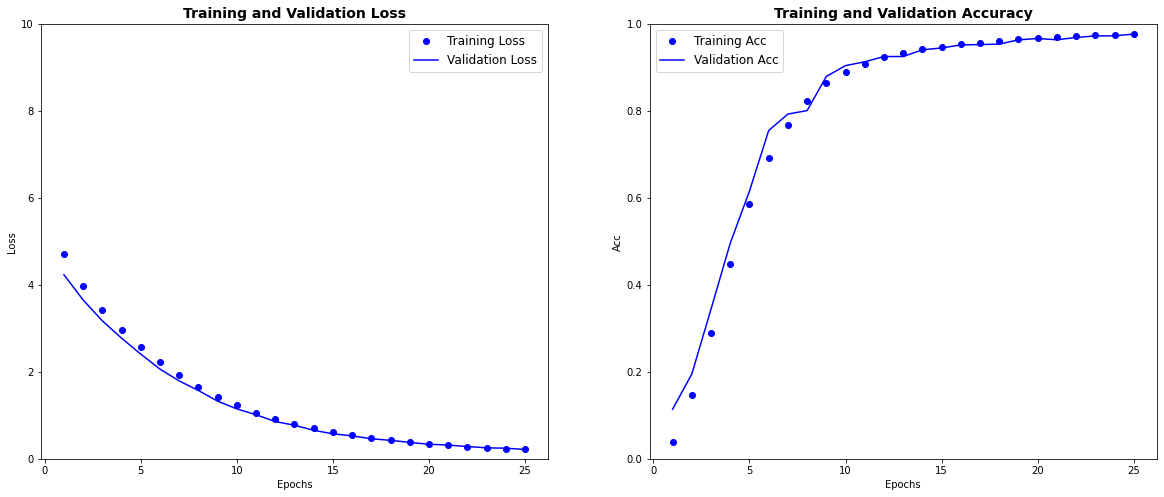

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) +1)

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend(fontsize=12)
plt.ylim(0, 10)

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(fontsize=12)
plt.ylim(0, 1)

plt.show()

Print results.

289/289 [==============================] - 0s 1ms/step - loss: 0.2144 - accuracy: 0.9766
[0.2143804281949997, 0.9766284227371216]


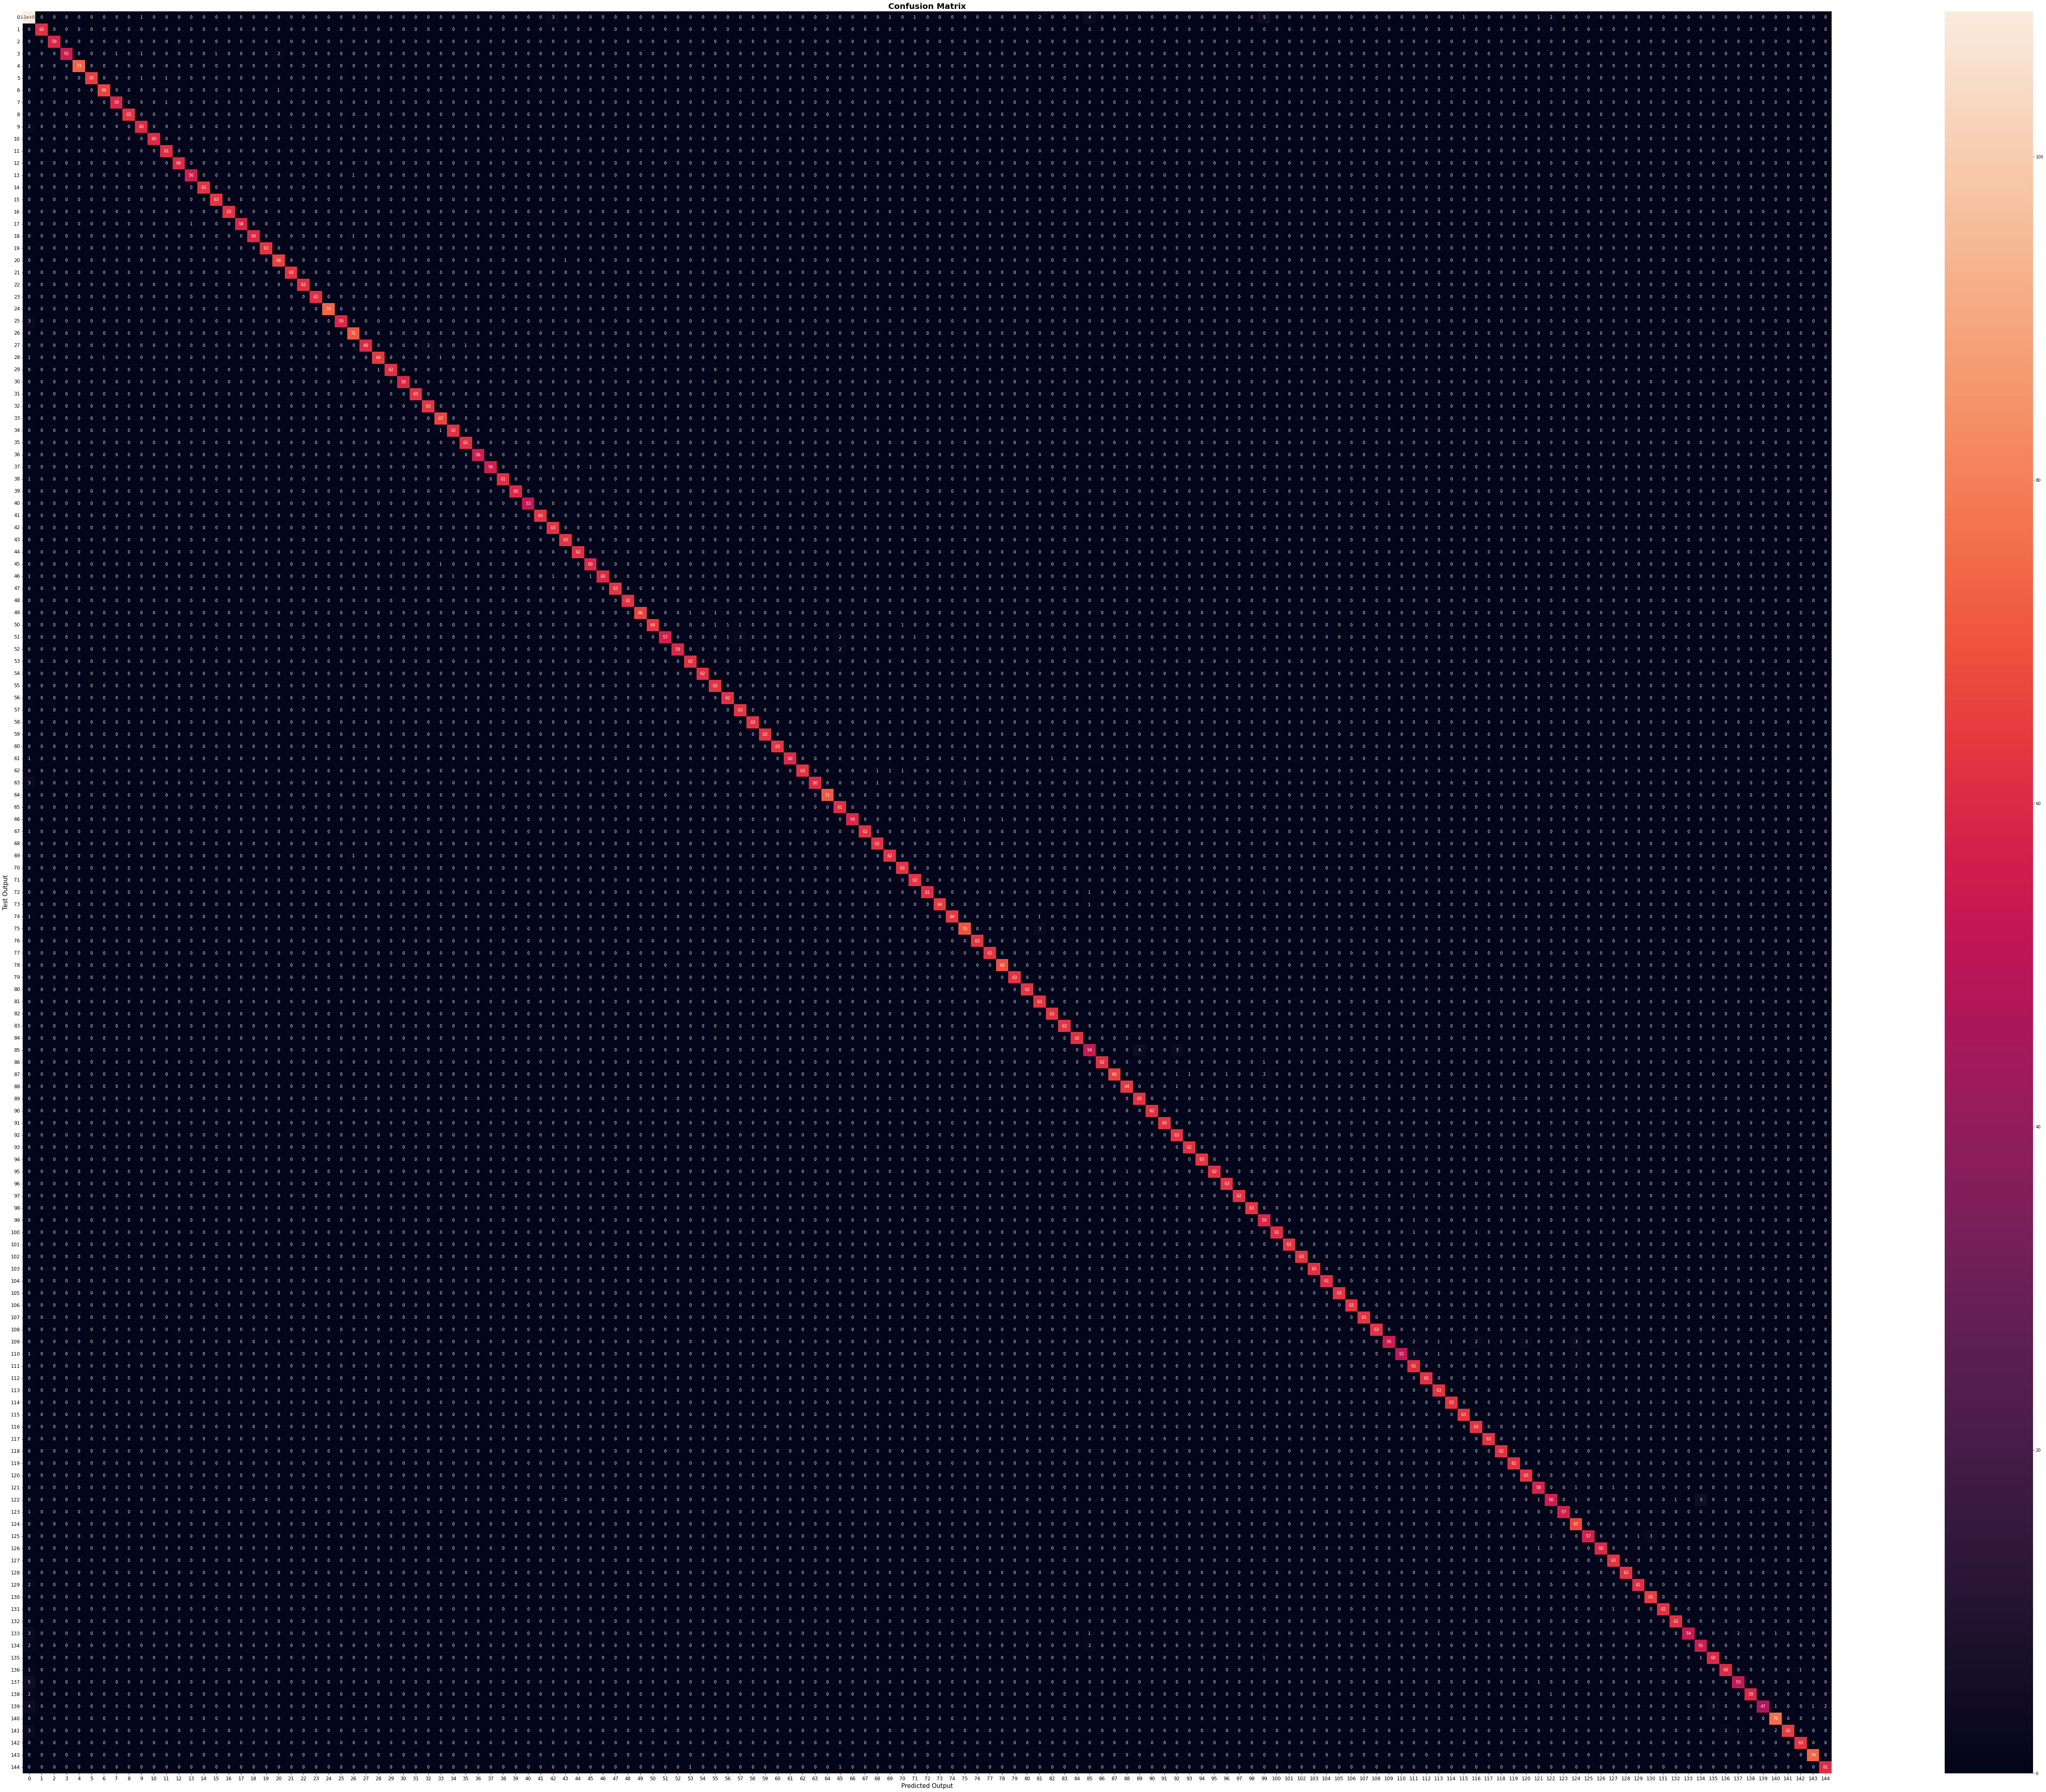

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

results = neural_net.evaluate(X[test_index], y[test_index])
print(results)

predictions = neural_net.predict(X[test_index])
y_pred = []
for i in range (0, predictions.shape[0]):
    y_pred.append(np.argmax(predictions[i]))

test_output = np.array(y[test_index], dtype='uint8')
pred_output = np.array(y_pred, dtype='uint8')
outputs, n_outputs = np.unique(test_output, return_counts=True)
length = len(outputs)

# Confusion matrix
plt.figure(figsize=(100,80))
cm = confusion_matrix(test_output, pred_output)
cm_df = pd.DataFrame(cm, index=outputs, columns=outputs)
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xlabel('Predicted Output', fontsize=15)
plt.ylabel('Test Output', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation='horizontal')

plt.show()

Save and export model.

In [9]:
neural_net.save('nn_led')

converter = tf.lite.TFLiteConverter.from_saved_model('nn_led')
tflite_model = converter.convert()

with open('nn_led.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: nn_led/assets
